<a href="https://colab.research.google.com/github/Jaynferrre/Quantitative-Gait-Analysis-for-Parkinson-s-Severity-Assesment/blob/main/GAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
google_sheets_url = "https://docs.google.com/spreadsheets/d/10CFq5qOsrmu-8OK_ucuCUDyIZuyU_wSfOnpVCz4-9bs/edit?usp=sharing"
sheet_id = google_sheets_url.split('/d/')[1].split('/edit')[0]
csv_export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid=0"

INPUT_FILE = 'demographics.csv'


response = requests.get(csv_export_url)
response.raise_for_status() # Raise an exception for bad status codes
with open(INPUT_FILE, 'wb') as f:
    f.write(response.content)
print(f"Successfully downloaded '{INPUT_FILE}' from Google Sheets.")
print("Click on refresh if file not visible in files section")


Successfully downloaded 'demographics.csv' from Google Sheets.
Click on refresh if file not visible in files section


In [ ]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# --- CONFIGURATION ---
INPUT_FILE = 'demographics.csv'
OUTPUT_FILE = 'demographics_synthetic_300_ordered.csv'
TARGET_ROWS = 300
RANDOM_SEED = 42

# 1. Load Data
df = pd.read_csv(INPUT_FILE)

# 2. Preprocessing
# We include Study and Group in training to learn their distribution
train_cols = [
    'Study', 'Group', 'Gender', 'Age',
    'Height (meters)', 'Weight (kg)', 'HoehnYahr',
    'UPDRS', 'UPDRSM', 'TUAG', 'Speed_01 (m/sec)', 'Speed_10'
]

# Work on a copy
data = df[train_cols].copy()

# Encode Categorical Variables
cat_cols = ['Study', 'Group', 'Gender']
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders[col] = le

# Impute Missing Values (Required for GMM)
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data)

# 3. Bootstrapping
# Resample to stabilize the statistical properties
bootstrapped_data = resample(
    data_imputed,
    replace=True,
    n_samples=len(data_imputed),
    random_state=RANDOM_SEED
)

# 4. Gaussian Mixture Model
# Fit the model to the bootstrapped data
gmm = GaussianMixture(
    n_components=2,
    covariance_type='full',
    random_state=RANDOM_SEED
)
gmm.fit(bootstrapped_data)

# 5. Generate Synthetic Data
# Sample 300 new rows
generated_data, _ = gmm.sample(n_samples=TARGET_ROWS)
df_new = pd.DataFrame(generated_data, columns=train_cols)

# 6. Decode Categorical Columns
for col in cat_cols:
    # Round to nearest integer to map back to category index
    df_new[col] = df_new[col].round().astype(int).clip(0, len(encoders[col].classes_) - 1)
    df_new[col] = encoders[col].inverse_transform(df_new[col])

# 7. ENFORCE ORIGINAL ROW ORDERING
# The original file structure is:
# 1st: All PD patients (Sub-sorted by Study: Ga -> Ju -> Si)
# 2nd: All CO patients (Sub-sorted by Study: Ga -> Ju -> Si)

# Create ranking columns to sort by
# Group: PD comes first (0), CO comes second (1)
df_new['Group_Rank'] = df_new['Group'].map({'PD': 0, 'CO': 1})

# Study: Ga (0) -> Ju (1) -> Si (2)
df_new['Study_Rank'] = df_new['Study'].map({'Ga': 0, 'Ju': 1, 'Si': 2})

# Sort the 300 rows based on this hierarchy
df_new = df_new.sort_values(by=['Group_Rank', 'Study_Rank'])

# 8. Clean Up & Rename Columns
rename_map = {
    'Height (meters)': 'Height_m',
    'Weight (kg)': 'Weight_kg',
    'TUAG': 'TUAG_sec',
    'Speed_01 (m/sec)': 'Speed_01_mps',
    'Speed_10': 'Speed_10_mps'
}
df_new.rename(columns=rename_map, inplace=True)

# 9. Value Constraints (Clean synthetic artifacts)
df_new['Age'] = df_new['Age'].clip(30, 95).round().astype(int)
df_new['Height_m'] = df_new['Height_m'].clip(1.4, 2.0).round(2)
df_new['Weight_kg'] = df_new['Weight_kg'].clip(40, 120).round(1)
df_new['HoehnYahr'] = df_new['HoehnYahr'].clip(0, 5).round(1)
df_new['UPDRS'] = df_new['UPDRS'].clip(0).round(0)
df_new['UPDRSM'] = df_new['UPDRSM'].clip(0).round(0)
df_new['TUAG_sec'] = df_new['TUAG_sec'].clip(0).round(2)
df_new['Speed_01_mps'] = df_new['Speed_01_mps'].clip(0).round(3)
df_new['Speed_10_mps'] = df_new['Speed_10_mps'].clip(0).round(3)

# 10. Calculate BMI
df_new['BMI'] = (df_new['Weight_kg'] / (df_new['Height_m'] ** 2)).round(2)

# 11. Assign IDs (PT001 to PT300)
# IDs are assigned *after* the sort, so PT001 is the first PD patient from 'Ga'
df_new['ID'] = [f'PT{i:03d}' for i in range(1, TARGET_ROWS + 1)]

# 12. Final Column Selection
final_order = [
    'ID', 'Study', 'Age', 'Gender', 'Height_m', 'Weight_kg',
    'BMI', 'TUAG_sec', 'Speed_01_mps', 'Speed_10_mps',
    'UPDRS', 'UPDRSM', 'HoehnYahr'
]
df_final = df_new[final_order]

# Save
df_final.to_csv(OUTPUT_FILE, index=False)
print(f"Generated {OUTPUT_FILE} with correct block ordering (PD->CO).")
print(df_final.head())

Generated demographics_synthetic_300_ordered.csv with correct block ordering (PD->CO).
       ID Study  Age Gender  Height_m  Weight_kg    BMI  TUAG_sec  \
20  PT001    Ga   72   male       2.0       90.3  22.58      9.64   
25  PT002    Ga   64   male       1.4       80.2  40.92     13.81   
39  PT003    Ga   66   male       2.0       55.9  13.98     16.48   
40  PT004    Ga   75   male       2.0       81.5  20.38     13.34   
41  PT005    Ga   74   male       2.0       84.1  21.02      8.15   

    Speed_01_mps  Speed_10_mps  UPDRS  UPDRSM  HoehnYahr  
20         0.813         1.070   17.0    13.0        0.7  
25         1.004         1.044   14.0     8.0        1.0  
39         1.101         0.729   29.0    19.0        2.0  
40         0.910         0.871   50.0    34.0        2.4  
41         1.358         1.094    0.0     4.0        0.9  


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

df_final.shape

(300, 13)

In [ ]:
df_final.head(5)

,ID,Study,Age,Gender,Height_m,Weight_kg,BMI,TUAG_sec,Speed_01_mps,Speed_10_mps,UPDRS,UPDRSM,HoehnYahr
20,PT001,Ga,72,male,2.0,90.3,22.58,9.64,0.813,1.070,17.0,13.0,0.7
25,PT002,Ga,64,male,1.4,80.2,40.92,13.81,1.004,1.044,14.0,8.0,1.0
39,PT003,Ga,66,male,2.0,55.9,13.98,16.48,1.101,0.729,29.0,19.0,2.0
40,PT004,Ga,75,male,2.0,81.5,20.38,13.34,0.910,0.871,50.0,34.0,2.4
41,PT005,Ga,74,male,2.0,84.1,21.02,8.15,1.358,1.094,0.0,4.0,0.9


In [ ]:
df_final.isnull().sum()

,0
ID,0
Study,0
Age,0
Gender,0
Height_m,0
Weight_kg,0
BMI,0
TUAG_sec,0
Speed_01_mps,0
Speed_10_mps,0


In [ ]:
df_final["HoehnYahr"] = df_final["HoehnYahr"].round().astype(int)
df_final['Gender'] = df_final['Gender'].map({'male': 0, 'female': 1})
df_final.head(5)

/tmp/ipython-input-3589549054.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final["HoehnYahr"] = df_final["HoehnYahr"].round().astype(int)
/tmp/ipython-input-3589549054.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Gender'] = df_final['Gender'].map({'male': 0, 'female': 1})


,ID,Study,Age,Gender,Height_m,Weight_kg,BMI,TUAG_sec,Speed_01_mps,Speed_10_mps,UPDRS,UPDRSM,HoehnYahr
20,PT001,Ga,72,0,2.0,90.3,22.58,9.64,0.813,1.070,17.0,13.0,1
25,PT002,Ga,64,0,1.4,80.2,40.92,13.81,1.004,1.044,14.0,8.0,1
39,PT003,Ga,66,0,2.0,55.9,13.98,16.48,1.101,0.729,29.0,19.0,2
40,PT004,Ga,75,0,2.0,81.5,20.38,13.34,0.910,0.871,50.0,34.0,2
41,PT005,Ga,74,0,2.0,84.1,21.02,8.15,1.358,1.094,0.0,4.0,1


In [ ]:
df_final[['HoehnYahr','Age','BMI','TUAG_sec','Speed_01_mps','Speed_10_mps']].corr()

,HoehnYahr,Age,BMI,TUAG_sec,Speed_01_mps,Speed_10_mps
HoehnYahr,1.000000,-0.061154,-0.032476,0.290369,-0.434079,-0.454573
Age,-0.061154,1.000000,-0.109108,0.391525,-0.347519,-0.066069
BMI,-0.032476,-0.109108,1.000000,-0.013925,0.059968,0.137346
TUAG_sec,0.290369,0.391525,-0.013925,1.000000,-0.483522,-0.382154
Speed_01_mps,-0.434079,-0.347519,0.059968,-0.483522,1.000000,0.434494
Speed_10_mps,-0.454573,-0.066069,0.137346,-0.382154,0.434494,1.000000


In [ ]:
cols = ['Age','Height_m','Weight_kg','BMI','TUAG_sec',
        'Speed_01_mps','Speed_10_mps','UPDRS','UPDRSM']

def remove_outliers(df_input, columns):
    df1 = df_input.copy()
    for col in columns:
        Q1 = df1[col].quantile(0.25)
        Q3 = df1[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        df1 = df1[(df1[col] >= lower) & (df1[col] <= upper)]
    return df1

df_final = remove_outliers(df_final, cols)
df_final.shape

(249, 13)

In [ ]:
df_final['HoehnYahr'].value_counts()

,count
HoehnYahr,
2,171
1,45
3,21
0,11
4,1


In [ ]:
df_current = df_final.copy()
df_current["HoehnYahr"] = df_current["HoehnYahr"].round().astype(int)
# The 'Gender' column was already mapped in an earlier cell.
# Re-mapping it here causes existing 0s and 1s to become NaN.
# df_current['Gender'] = df_current['Gender'].map({'male': 0, 'female': 1}) # REMOVED
df_current = df_current.drop(columns=['ID', 'Study'])

# Remove rows where HoehnYahr has only 1 instance to allow for stratified split
# Based on df_final['HoehnYahr'].value_counts(), class 4 has 1 instance.
df_current = df_current[df_current['HoehnYahr'] != 4]

y = df_current['HoehnYahr']
df_model = df_final.copy()
# Hoehn & Yahr 0 is Control (Healthy), anything > 0 is Parkinson's
df_model['HoehnYahr'] = df_model['HoehnYahr'].round().astype(int)
df_model['Is_PD'] = df_model['HoehnYahr'].apply(lambda x: 0 if x == 0 else 1)
print("Class Balance (0=Healthy, 1=PD):")
print(df_model['Is_PD'].value_counts())
# Instability = Time to perform task / Walking Speed
# (High Time + Low Speed = High Instability)
df_model['Instability_Index'] = df_model['TUAG_sec'] / (df_model['Speed_01_mps'] + 0.01)
if df_model['Gender'].dtype == 'object':
    df_model['Gender'] = df_model['Gender'].map({'male': 0, 'female': 1})

# FEATURE SETS (Age first)
features = [
    'Age', 'BMI', 'Gender',
    'TUAG_sec', 'Speed_01_mps', 'Speed_10_mps',
    'Instability_Index'
]
X = df_model[features]
y = df_model['Is_PD']

# --- 2. SPLIT & TRAIN ---
# Stratify is crucial here due to the imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale data (Important for Logistic Regression interpretation)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- 3. LOGISTIC REGRESSION (Binary) ---
# Use class_weight='balanced' to handle the skew (286 vs 14) automatically
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

print("\n==============================================")
print(" LOGISTIC REGRESSION RESULTS (Binary: PD Risk) ")
print("==============================================")
print(f"Accuracy : {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Recall   : {recall_score(y_test, y_pred_lr):.2f} (Sensitivity)")
print(f"F1 Score : {f1_score(y_test, y_pred_lr):.2f}")

# Interpreting Coefficients
# Negative Coefficient = Protective (Higher value -> Healthier)
# Positive Coefficient = Risk Factor (Higher value -> More likely PD)
coefs = log_reg.coef_[0]
print("\nFeature Interpretation:")
print(f"{'Feature':<20} | {'Coef':<8} | {'Effect'}")
print("-" * 50)
for f, c in zip(features, coefs):
    effect = "Protective (Healthy)" if c < 0 else "Risk Factor (PD)"
    print(f"{f:<20} | {c:+.4f}   | {effect}")

# --- 4. RANDOM FOREST ---
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("\n==============================================")
print(" RANDOM FOREST RESULTS ")
print("==============================================")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"F1 Score : {f1_score(y_test, y_pred_rf):.2f}")

# Feature Importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nTop Predictors (Random Forest):")
for i in range(len(features)):
    print(f"{features[indices[i]]:<20} : {importances[indices[i]]:.4f}")

Class Balance (0=Healthy, 1=PD):
Is_PD
1    238
0     11
Name: count, dtype: int64

 LOGISTIC REGRESSION RESULTS (Binary: PD Risk) 
Accuracy : 0.76
Recall   : 0.77 (Sensitivity)
F1 Score : 0.86

Feature Interpretation:
Feature              | Coef     | Effect
--------------------------------------------------
Age                  | -1.3449   | Protective (Healthy)
BMI                  | -0.3315   | Protective (Healthy)
Gender               | +0.4378   | Risk Factor (PD)
TUAG_sec             | -1.1131   | Protective (Healthy)
Speed_01_mps         | -1.7903   | Protective (Healthy)
Speed_10_mps         | -0.5400   | Protective (Healthy)
Instability_Index    | -0.0458   | Protective (Healthy)

 RANDOM FOREST RESULTS 
Accuracy : 0.96
F1 Score : 0.98

Top Predictors (Random Forest):
Speed_10_mps         : 0.2216
Speed_01_mps         : 0.1905
TUAG_sec             : 0.1540
Instability_Index    : 0.1447
Age                  : 0.1420
BMI                  : 0.1228
Gender               : 0.0244


In [ ]:
physical_cols = [
    'TUAG_sec',
    'Speed_01_mps',
    'Speed_10_mps'
]

df_current = df_final.copy()
df_current["HoehnYahr"] = df_current["HoehnYahr"].round().astype(int)
df_current['Is_PD'] = df_current['HoehnYahr'].apply(lambda x: 0 if x == 0 else 1)
# The 'Gender' column was already mapped in an earlier cell.
# Re-mapping it here causes existing 0s and 1s to become NaN.
if df_current['Gender'].dtype == 'object':
    df_current['Gender'] = df_current['Gender'].map({'male': 0, 'female': 1})
df_current = df_current.drop(columns=['ID', 'Study'])

# Remove rows where HoehnYahr has only 1 instance to allow for stratified split
# Based on df_final['HoehnYahr'].value_counts(), class 4 has 1 instance.
df_current = df_current[df_current['HoehnYahr'] != 4]

# Calculate Instability_Index as derived in the previous cell
df_current['Instability_Index'] = df_current['TUAG_sec'] / (df_current['Speed_01_mps'] + 0.01)

# Add Instability_Index to the physical features
physical_cols.append('Instability_Index')

y = df_current['Is_PD']
X = df_current[physical_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# LOGISTIC REGRESSION
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_res)
X_test_sc = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_sc, y_train_res)
y_pred_lr = log_reg.predict(X_test_sc)

print("\n==============================")
print("LOGISTIC REGRESSION (Physical Gait Features)")
print("==============================")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='macro'))
print("Recall   :", recall_score(y_test, y_pred_lr, average='macro'))
print("F1-score :", f1_score(y_test, y_pred_lr, average='macro'))
# Coefficients
print("\nLogistic Regression Coefficients:")
print("(Negative = Protective/Healthy, Positive = Risk/PD)")
print("-" * 60)
lr_coef = log_reg.coef_[0]

for f, c in zip(physical_cols, lr_coef):
    effect = "Protective (Healthy)" if c < 0 else "Risk Factor (PD)"
    print(f"Feature: {f:18s} | Coef: {c:+.4f} | {effect}")

# --- RANDOM FOREST ---
rf = RandomForestClassifier(
    n_estimators=250,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("\n==============================")
print("RANDOM FOREST (Physical Gait Features - Binary)")
print("==============================")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"F1-score : {f1_score(y_test, y_pred_rf):.2f}")

# Feature Importance
print("\nRandom Forest Feature Importances:")
rf_imp = rf.feature_importances_
indices = np.argsort(rf_imp)[::-1] # Sort descending

for i in indices:
    print(f"Feature: {physical_cols[i]:18s} | Importance: {rf_imp[i]:.4f}")


LOGISTIC REGRESSION (Physical Gait Features)
Accuracy : 0.76
Precision: 0.5285087719298246
Recall   : 0.6354166666666667
F1-score : 0.5016611295681063

Logistic Regression Coefficients:
(Negative = Protective/Healthy, Positive = Risk/PD)
------------------------------------------------------------
Feature: TUAG_sec           | Coef: -0.6714 | Protective (Healthy)
Feature: Speed_01_mps       | Coef: -1.8639 | Protective (Healthy)
Feature: Speed_10_mps       | Coef: -1.0234 | Protective (Healthy)
Feature: Instability_Index  | Coef: -1.1089 | Protective (Healthy)

RANDOM FOREST (Physical Gait Features - Binary)
Accuracy : 0.86
F1-score : 0.92

Random Forest Feature Importances:
Feature: Speed_10_mps       | Importance: 0.3652
Feature: Speed_01_mps       | Importance: 0.2708
Feature: TUAG_sec           | Importance: 0.2191
Feature: Instability_Index  | Importance: 0.1449


In [ ]:
combined_cols = [
    'Age',
    'BMI',
    'Gender',
    'TUAG_sec',
    'Speed_01_mps',
    'Speed_10_mps'
]

df_current = df_final.copy()
df_current["HoehnYahr"] = df_current["HoehnYahr"].round().astype(int)
df_current['Is_PD'] = df_current['HoehnYahr'].apply(lambda x: 0 if x == 0 else 1)

df_current = df_current.drop(columns=['ID', 'Study'])

# Remove rows where HoehnYahr has only 1 instance to allow for stratified split
# Based on df_final['HoehnYahr'].value_counts(), class 4 has 1 instance.
df_current = df_current[df_current['HoehnYahr'] != 4]

# Calculate Instability_Index as derived in the previous cell
df_current['Instability_Index'] = df_current['TUAG_sec'] / (df_current['Speed_01_mps'] + 0.01)

# Add Instability_Index to the combined features
combined_cols.append('Instability_Index')

y = df_current['Is_PD']
X = df_current[combined_cols]

# Train–Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# SMOTE (fix imbalance)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# LOGISTIC REGRESSION
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_res)
X_test_sc = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train_sc, y_train_res)
y_pred_lr = log_reg.predict(X_test_sc)
print("==============================================")
print(" LOGISTIC REGRESSION (Combined Features - Binary) ")
print("==============================================")
print(f"Accuracy : {accuracy_score(y_test, y_pred_lr):.2f}")
print(f"Recall   : {recall_score(y_test, y_pred_lr):.2f}")
print(f"F1-score : {f1_score(y_test, y_pred_lr):.2f}")

# Coefficients
print("\nLogistic Regression Coefficients:")
print("(Negative = Protective/Healthy, Positive = Risk/PD)")
print("-" * 60)
lr_coef = log_reg.coef_[0]

for f, c in zip(combined_cols, lr_coef):
    effect = "Protective (Healthy)" if c < 0 else "Risk Factor (PD)"
    print(f"Feature: {f:18s} | Coef: {c:+.4f} | {effect}")

# --- RANDOM FOREST ---
rf = RandomForestClassifier(
    n_estimators=250,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("\n==============================================")
print(" RANDOM FOREST (Combined Features - Binary) ")
print("==============================================")
print(f"Accuracy : {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"F1-score : {f1_score(y_test, y_pred_rf):.2f}")

# Feature Importance
print("\nRandom Forest Feature Importances:")
rf_imp = rf.feature_importances_
indices = np.argsort(rf_imp)[::-1]

for i in indices:
    print(f"Feature: {combined_cols[i]:18s} | Importance: {rf_imp[i]:.4f}")

 LOGISTIC REGRESSION (Combined Features - Binary) 
Accuracy : 0.86
Recall   : 0.88
F1-score : 0.92

Logistic Regression Coefficients:
(Negative = Protective/Healthy, Positive = Risk/PD)
------------------------------------------------------------
Feature: Age                | Coef: -1.2400 | Protective (Healthy)
Feature: BMI                | Coef: -0.1610 | Protective (Healthy)
Feature: Gender             | Coef: +0.9360 | Risk Factor (PD)
Feature: TUAG_sec           | Coef: -0.8402 | Protective (Healthy)
Feature: Speed_01_mps       | Coef: -2.5930 | Protective (Healthy)
Feature: Speed_10_mps       | Coef: -0.5749 | Protective (Healthy)
Feature: Instability_Index  | Coef: -0.6672 | Protective (Healthy)

 RANDOM FOREST (Combined Features - Binary) 
Accuracy : 0.92
F1-score : 0.96

Random Forest Feature Importances:
Feature: Speed_10_mps       | Importance: 0.2126
Feature: Speed_01_mps       | Importance: 0.2064
Feature: Age                | Importance: 0.1556
Feature: TUAG_sec          

/tmp/ipython-input-278167404.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(combined_cols)[indices], palette="viridis")
/tmp/ipython-input-278167404.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Condition', y='Instability_Index', palette={'Healthy': 'green', 'Parkinsons': 'red'})


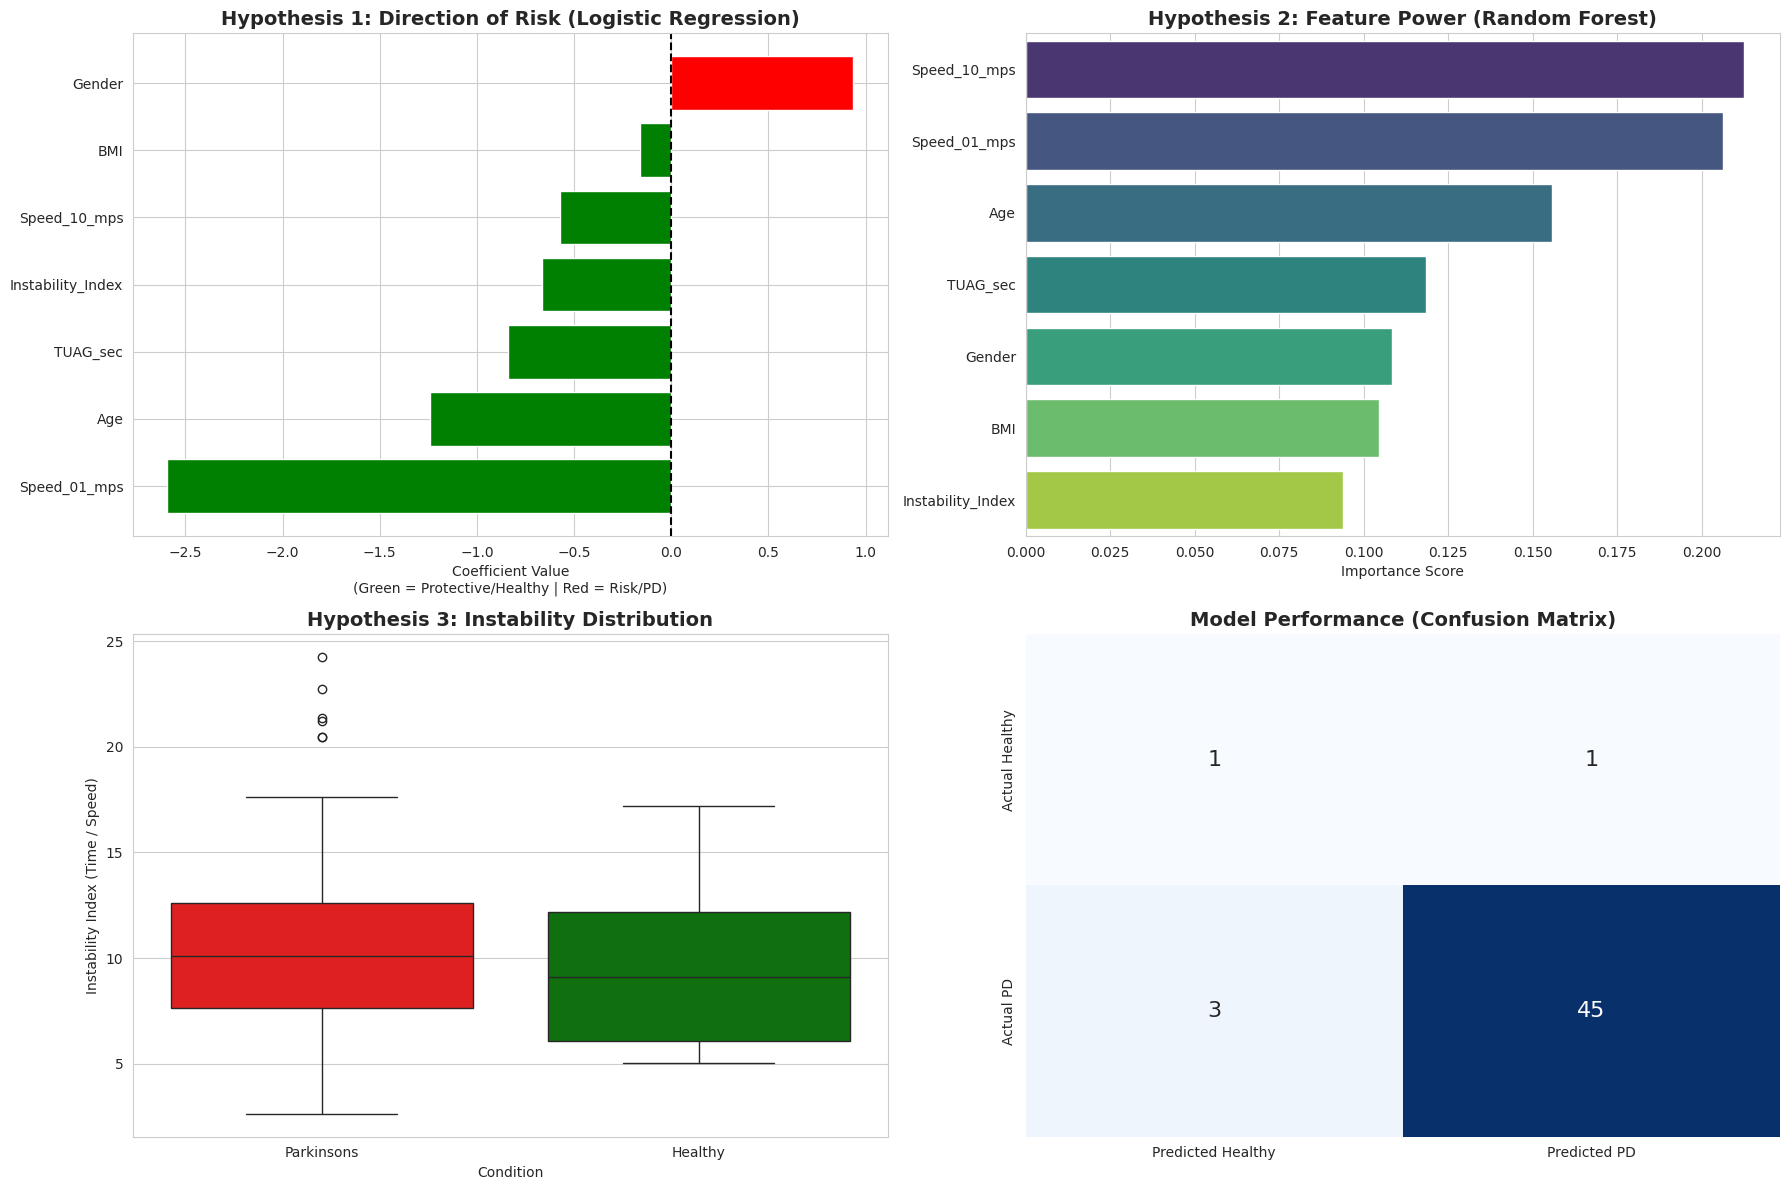

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# -------------------------------------------------------
# PLOT 1: Logistic Regression Coefficients (Direction of Risk)
# -------------------------------------------------------
plt.subplot(2, 2, 1)
coefs = log_reg.coef_[0]
colors = ['red' if c > 0 else 'green' for c in coefs]
# Sort for better visual
sorted_idx = np.argsort(coefs)
plt.barh(np.array(combined_cols)[sorted_idx], coefs[sorted_idx], color=np.array(colors)[sorted_idx])
plt.axvline(0, color='black', linestyle='--')
plt.title('Hypothesis 1: Direction of Risk (Logistic Regression)', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value\n(Green = Protective/Healthy | Red = Risk/PD)')

# -------------------------------------------------------
# PLOT 2: Random Forest Feature Importance (What matters?)
# -------------------------------------------------------
plt.subplot(2, 2, 2)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
sns.barplot(x=importances[indices], y=np.array(combined_cols)[indices], palette="viridis")
plt.title('Hypothesis 2: Feature Power (Random Forest)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score')

# -------------------------------------------------------
# PLOT 3: The "Instability" Separation (Box Plot)
# -------------------------------------------------------
plt.subplot(2, 2, 3)
# Create a temp dataframe for plotting
plot_df = df_current.copy()
plot_df['Condition'] = plot_df['Is_PD'].map({0: 'Healthy', 1: 'Parkinsons'})

sns.boxplot(data=plot_df, x='Condition', y='Instability_Index', palette={'Healthy': 'green', 'Parkinsons': 'red'})
plt.title('Hypothesis 3: Instability Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Instability Index (Time / Speed)')

# -------------------------------------------------------
# PLOT 4: Confusion Matrix (Accuracy)
# -------------------------------------------------------
plt.subplot(2, 2, 4)
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Healthy', 'Predicted PD'],
            yticklabels=['Actual Healthy', 'Actual PD'], annot_kws={"size": 16})
plt.title('Model Performance (Confusion Matrix)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()